In [15]:
#Import needed modules
import requests
import collections
import time

import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite

from datetime import datetime
from dateutil.parser import parse

%matplotlib inline

In [16]:
#Pull JSON data from CitiBike website
r = requests.get('http://www.citibikenyc.com/stations/json')

#Pull JSON data into Pandas DataFrame
bikedata=pd.io.json.json_normalize(r.json()['stationBeanList'])

In [17]:
#Build SQLite database with reference table and bike data table
con = lite.connect('citibike.db')
cur = con.cursor()

#Create base sql query to insert data
sql = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, "\
        "stAddress2, longitude, postalCode, testStation, stAddress1, stationName, "\
        "landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"
        
#Collect station ids
id_list=bikedata['id'].tolist()
id_list=['_'+str(x)+' INT' for x in id_list]

with con:
    cur.execute('DROP TABLE IF EXISTS citibike_reference')
    cur.execute('DROP TABLE IF EXISTS available_bikes')
    
    cur.execute('CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, '\
                                                  'city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, '\
                                                  'postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, '\
                                                  'landMark TEXT, latitude NUMERIC, location TEXT)')
    
    for station in r.json()['stationBeanList']:
        cur.execute(sql,(station['id'],station['totalDocks'],station['city'],
                         station['altitude'],station['stAddress2'],station['longitude'],
                         station['postalCode'],station['testStation'],station['stAddress1'],
                         station['stationName'],station['landMark'],station['latitude'],
                         station['location']))
    
    cur.execute("CREATE TABLE available_bikes (execution_time INT, " + ", ".join(id_list)+");")

In [18]:
bikeid=collections.defaultdict(int)

for itr in range(0,60):
    print('Iteration: %d' % itr)
    #Pull JSON data from CitiBike website
    r = requests.get('http://www.citibikenyc.com/stations/json')
    
    #Pull execution time
    exec_time = parse(r.json()['executionTime'])

    #Create dictionary for available bikes per station
    for station in r.json()['stationBeanList']:
        bikeid[station['id']] = station['availableBikes']

    with con:
        #Insert execution time into database
        cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', 
                        (exec_time.strftime("%Y%m%d_%H%M%S"),))

        #Insert available bikes per station into database
        for key,value in bikeid.items():
            cur.execute('UPDATE available_bikes SET _' + str(key) + ' = '\
                        + str(value) + " WHERE execution_time = "\
                        + "'"+exec_time.strftime("%Y%m%d_%H%M%S")+"'"+";")
    
    #Pause for 60 seconds till next iteration
    time.sleep(1)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59


The most active station is station id 515 at W 43 St & 10 Ave (latitude: 40.76009437 longitude: -73.99461843)

With 40 bicycles coming and going in the hour between 2016-07-28 20:38:26 and 2016-07-28 20:38:26


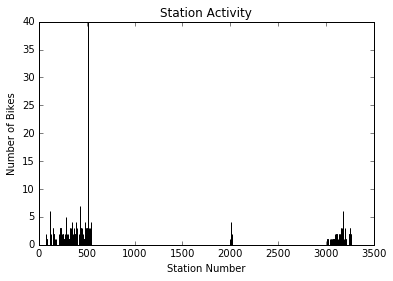

In [19]:
#Pull bike data from database
bikedata = pd.read_sql_query('SELECT * FROM available_bikes '\
                             'ORDER BY execution_time',con,index_col='execution_time')

#Find station activity over an hour
hourdelta=collections.defaultdict(int)

for key,val in bikedata.iteritems():      
    hourdelta[int(key.replace("_",""))] = sum([abs(val[i]-val[i-1]) for i in range(1,len(val))])

#Pull specific station data from database
data=cur.execute('SELECT id, stationname, latitude, longitude '\
                 'FROM citibike_reference WHERE id = ?', (max(hourdelta, key=hourdelta.get),)).fetchone()

#Print results on most active station
print('The most active station is station id %s at %s (latitude: %s longitude: %s)\n' % data)
print('With %d bicycles coming and going in the hour between %s and %s' 
          % (hourdelta[data[0]],datetime.strptime(bikedata.index[0],"%Y%m%d_%H%M%S"),
             datetime.strptime(bikedata.index[1],"%Y%m%d_%H%M%S")))

#Plot station data
plt.bar(hourdelta.keys(),hourdelta.values())
plt.title('Station Activity')
plt.xlabel('Station Number')
plt.ylabel('Number of Bikes')

In [20]:
#Station 490 is located near several major factilities; 
#Moynihan Station, Madison Sqaure Garden and Penn Station.
#There were no events at Madison Square Garden or 
#Moynihan Station on the 22nd.  There are other event spaces 
#in the area, such as a movie theater, but it's hard to imagine 
#these smaller venues drawing enough people to generate this level
#of activity.  Penn Station is the main railroad station for NYC 
#and serves 600,000 commuters a day (Source: Wikipedia).
#Data was pulled at 6 PM on a Friday which is most likely 
#the (or near the) peak hour for commuters in a given day.  
#There are 25,000 commuters per hour assuming the commuter 
#volume is evenly distributed.  Therefore, only 1.1% of commuters 
#in that hour need to rent or return a bike to make this station 
#the most active.  Realistically, commuter volume won't be evenly 
#distributed but this assumption is sufficient for now.  
#This simple assessment doesn't account for individuals
#using the bike station but not commuting via Penn Station.